## Import Libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import joblib
import pickle
import os 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)

## Import and Split Data

In [107]:
graph_directory = "..\\graphs\\"
df = pd.read_csv('..\\data\\clean\\dataset.csv')

X = df.drop('class_value', axis=1)
y = df['class_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good']
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Define Model Configurations/Parameters

In [108]:
model_configs = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'max_iter': [1000, 2000, 3000],
            'penalty': ['l2', 'l1'],  # l1 only works with liblinear
            'class_weight': ['balanced', None],
            'warm_start': [True, False],
            'multi_class': ['auto', 'ovr', 'multinomial']  # multinomial only works with specific solvers
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            'var_smoothing': np.logspace(-11, -6, 10),  # More granular range
            'priors': [None]  # Can add custom priors if class distribution is known
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
            'degree': [2, 3, 4],  # For poly kernel
            'coef0': [0.0, 0.1, 0.5],  # For poly and sigmoid kernels
            'class_weight': ['balanced', None],
            'shrinking': [True, False],
            'probability': [True, False]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40, 50],  # Affects speed of tree algorithms
            'p': [1, 2],  # 1 for manhattan_distance, 2 for euclidean
            'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced', None],
            'min_impurity_decrease': [0.0, 0.01, 0.05],
            'max_leaf_nodes': [None, 50, 100]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'max_leaf_nodes': [None, 50, 100],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None],
            'min_impurity_decrease': [0.0, 0.01, 0.05],
            'oob_score': [True, False],  # Only available when bootstrap=True
            'warm_start': [True, False]
        }
    }
}

## Specific Purpose Functions

#### Confusion Matrix Plot Function

In [109]:
def plot_confusion_matrix(y_test, y_pred, model_name, class_names, graph_directory):
    """
    Plot and save confusion matrix
    """
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"{graph_directory}confusion_matrices\\{model_name.lower()} confusion matrix")
    plt.show()

#### Feature Importance Plot

In [110]:
def plot_feature_importance(model, model_name, feature_names, graph_directory):
    """
    Plot and save feature importance if the model supports it
    """
    try:
        if hasattr(model, 'coef_'):
            feature_importance = np.abs(model.coef_[0])
        elif hasattr(model, 'feature_importances_'):
            feature_importance = model.feature_importances_
        else:
            print(f"Model {model_name} doesn't support feature importance visualization")
            return
        
        plt.figure(figsize=(10, 6))
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        sns.barplot(x='importance', y='feature', data=feature_importance_df)
        plt.title(f'{model_name} - Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.savefig(f"{graph_directory}feature_importance\\{model_name.lower()} feature importance")
        plt.show()
        
        return feature_importance_df
    except Exception as e:
        print(f"Could not plot feature importance: {e}")
        return None

#### Decision Tree Structure Graph

In [111]:
def plot_decision_tree(model, file_name, title):
    directory = "other\\"
    
    plt.figure(figsize=(20,10))
    plot_tree(
        model, 
        feature_names=feature_names, 
        class_names=class_names, 
        filled=True, 
        rounded=True,
        fontsize=5
    )
    plt.title(title)
    plt.tight_layout()
    plt.savefig(graph_directory + directory + file_name)
    plt.show()

#### Save Model Function

In [112]:
def save_model(model, model_name, save_formats=['joblib', 'pickle']):
    path = "..\\models\\"
    model_name = model_name.lower().replace(" ", "_")

    os.makedirs(f'{path}{model_name.lower().replace(" ", "_")}', exist_ok=True)
    

    # Save in specified formats
    if 'joblib' in save_formats:
        joblib_path = f'{path}{model_name}\\{model_name}_model.joblib'
        joblib.dump(model, joblib_path)
        print(f"Model saved as Joblib: {joblib_path}")
    
    if 'pickle' in save_formats:
        pickle_path = f'{path}{model_name}\\{model_name}_model.pkl'
        with open(pickle_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as Pickle: {pickle_path}")

#### Model Metrics Evaluation

In [113]:
def evaluate_model_metrics(model, X_train, X_test, y_train, y_test, model_name, class_names):
    """
    Evaluate a model using various classification metrics
    """
    # Train the model and make predictions
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    save_model(model, model_name)
    
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'model_name': model_name,
        'training_time': training_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    
    # Print results
    print(f"\n{model_name} Model Performance:")
    for metric, value in metrics.items():
        if metric not in ['model_name']:
            if metric == 'training_time':
                print(f"{metric.capitalize()}: {value:.2f} seconds")
            else:
                print(f"{metric.capitalize()}: {value:.4f}")
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    return metrics, y_pred

#### Train and Evaluate All Models Function

In [114]:
def evaluate_all_models(model_configs, X_train, X_test, y_train, y_test, class_names, feature_names, graph_directory):
    """
    Evaluate all models and return their metrics
    """
    all_metrics = []
    
    for model_name, config in model_configs.items():
        print(f"\nEvaluating {model_name}...")
        
        # Get the model from config
        model = config['model']
        
        # Evaluate model
        metrics, y_pred = evaluate_model_metrics(
            model, X_train, X_test, y_train, y_test, model_name, class_names
        )
        
        # Plot confusion matrix
        plot_confusion_matrix(
            y_test, y_pred, model_name, class_names, graph_directory
        )
        
        # Plot feature importance
        plot_feature_importance(
            model, model_name, feature_names, graph_directory
        )

        if "Tree" in model_name:
            file_name = "decision_tree_structure_graph"
            title = "Decision Tree Structure Graph"
            plot_decision_tree(model, file_name, title)
        
        all_metrics.append(metrics)
    
    # Create DataFrame with all metrics
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df.set_index('model_name', inplace=True)
    
    return metrics_df





#### Apply Hyperparameter Tuning

In [115]:
def optimize_model(model, param_grid, X_train, y_train, cv_splits=5):
    """
    Perform hyperparameter tuning using GridSearchCV
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1
    )
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    optimization_time = time.time() - start_time
    
    print("\nBest parameters:", grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Optimization time: {optimization_time:.2f} seconds")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


#### Optimization Function

In [116]:
def optimize_best_model(best_model_name, model_configs, X_train, y_train):
    """
    Optimize the best performing model using its predefined parameter grid
    """
    if best_model_name not in model_configs:
        raise ValueError(f"Model {best_model_name} not found in configurations")
    
    config = model_configs[best_model_name]
    model = config['model']
    param_grid = config['param_grid']
    
    print(f"\nOptimizing {best_model_name}...")
    return optimize_model(model, param_grid, X_train, y_train)


## Training, Evaluation and Visualization

### Train and Evaluate All Models


Evaluating Logistic Regression...
Model saved as Joblib: ..\models\logistic_regression\logistic_regression_model.joblib
Model saved as Pickle: ..\models\logistic_regression\logistic_regression_model.pkl

Logistic Regression Model Performance:
Training_time: 0.03 seconds
Accuracy: 0.8382
Precision: 0.7218
Recall: 0.6377
F1_score: 0.6727

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.55      0.62        77
  Acceptable       0.58      0.50      0.54        14
        Good       0.88      0.97      0.92       242
   Very Good       0.70      0.54      0.61        13

    accuracy                           0.84       346
   macro avg       0.72      0.64      0.67       346
weighted avg       0.83      0.84      0.83       346



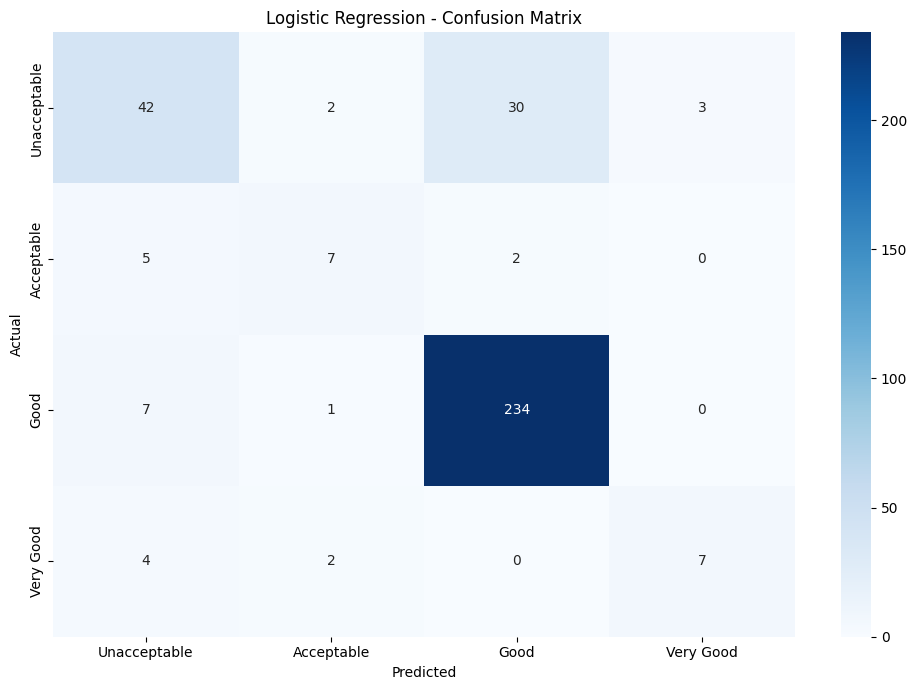

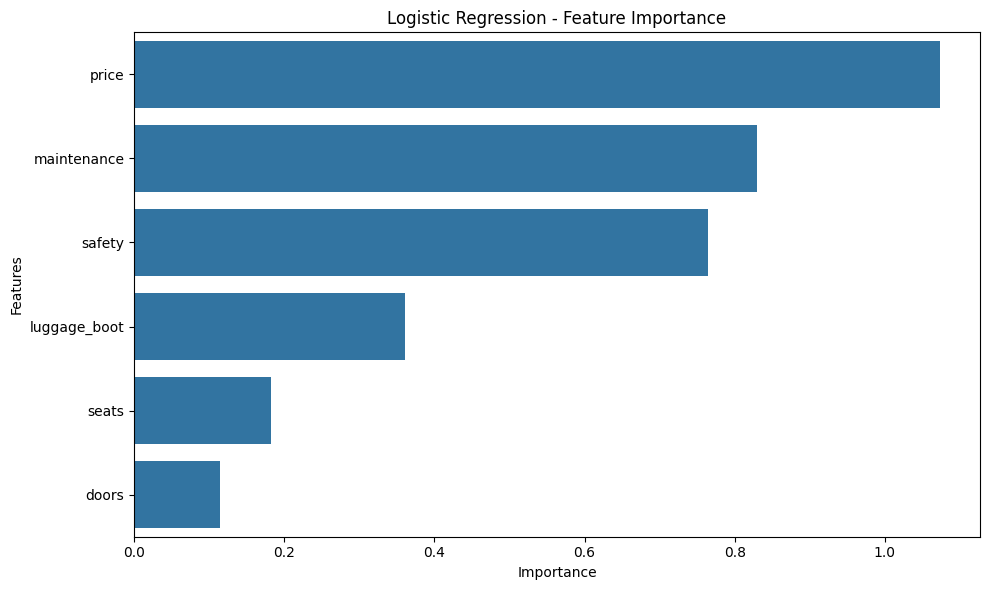


Evaluating Naive Bayes...
Model saved as Joblib: ..\models\naive_bayes\naive_bayes_model.joblib
Model saved as Pickle: ..\models\naive_bayes\naive_bayes_model.pkl

Naive Bayes Model Performance:
Training_time: 0.00 seconds
Accuracy: 0.7023
Precision: 0.5515
Recall: 0.5691
F1_score: 0.4377

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.74      0.18      0.29        77
  Acceptable       0.43      0.21      0.29        14
        Good       0.86      0.88      0.87       242
   Very Good       0.18      1.00      0.30        13

    accuracy                           0.70       346
   macro avg       0.55      0.57      0.44       346
weighted avg       0.79      0.70      0.70       346



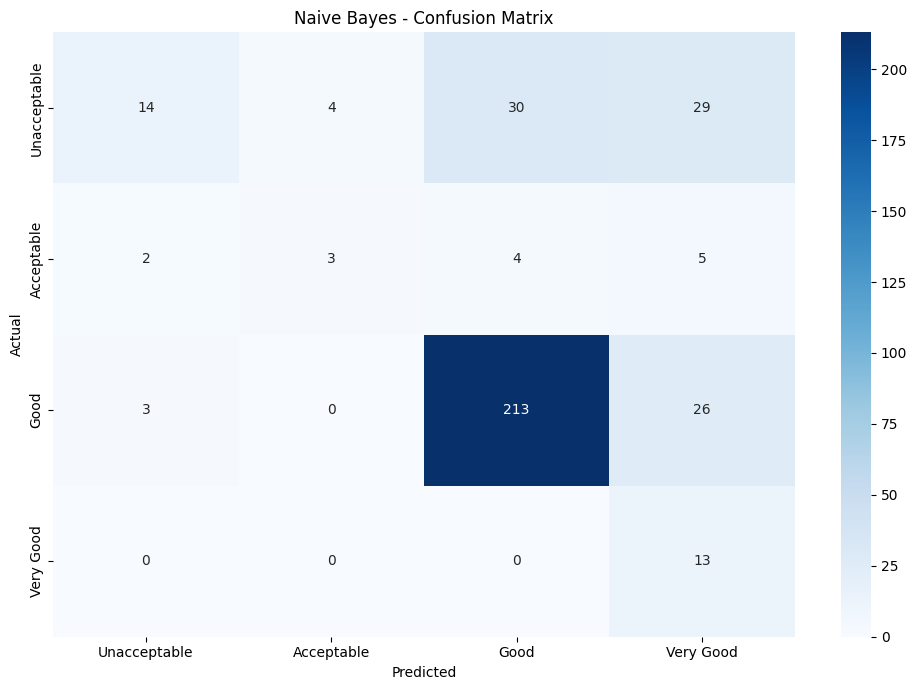

Model Naive Bayes doesn't support feature importance visualization

Evaluating SVC...
Model saved as Joblib: ..\models\svc\svc_model.joblib
Model saved as Pickle: ..\models\svc\svc_model.pkl

SVC Model Performance:
Training_time: 0.02 seconds
Accuracy: 0.9740
Precision: 0.9766
Recall: 0.9513
F1_score: 0.9630

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.91      0.97      0.94        77
  Acceptable       1.00      0.93      0.96        14
        Good       0.99      0.98      0.99       242
   Very Good       1.00      0.92      0.96        13

    accuracy                           0.97       346
   macro avg       0.98      0.95      0.96       346
weighted avg       0.98      0.97      0.97       346



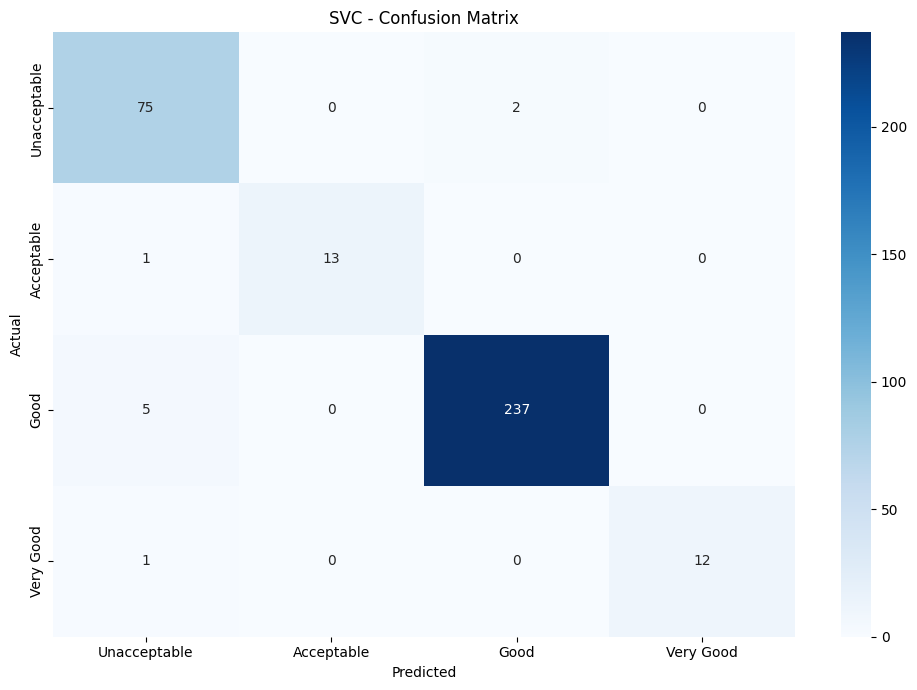

Model SVC doesn't support feature importance visualization

Evaluating KNN...
Model saved as Joblib: ..\models\knn\knn_model.joblib
Model saved as Pickle: ..\models\knn\knn_model.pkl

KNN Model Performance:
Training_time: 0.00 seconds
Accuracy: 0.9538
Precision: 0.9370
Recall: 0.8191
F1_score: 0.8653

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.88      0.95      0.91        77
  Acceptable       0.89      0.57      0.70        14
        Good       0.98      0.99      0.98       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.95       346
   macro avg       0.94      0.82      0.87       346
weighted avg       0.95      0.95      0.95       346



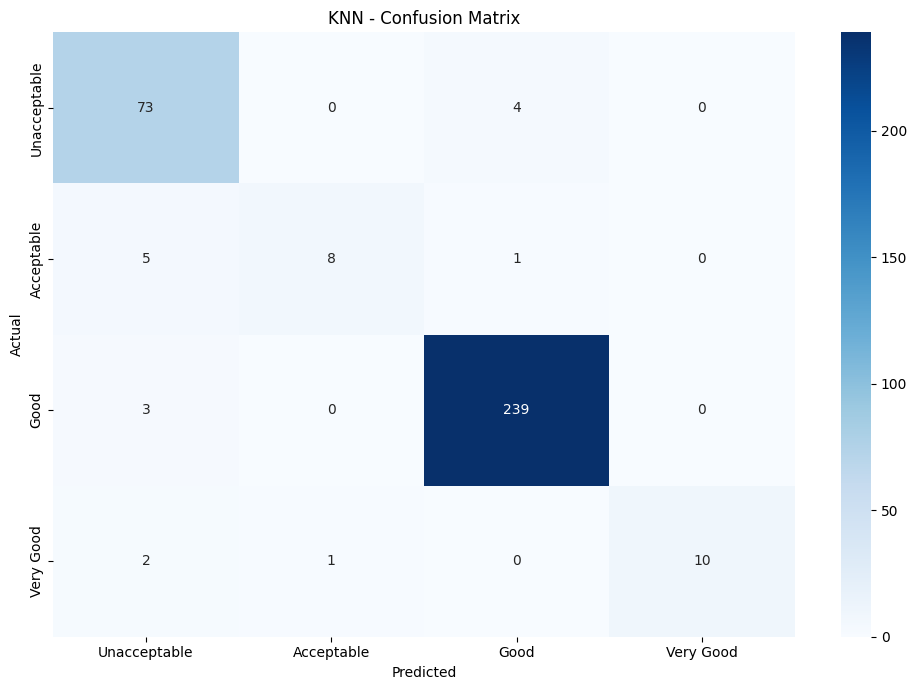

Model KNN doesn't support feature importance visualization

Evaluating Decision Tree...
Model saved as Joblib: ..\models\decision_tree\decision_tree_model.joblib
Model saved as Pickle: ..\models\decision_tree\decision_tree_model.pkl

Decision Tree Model Performance:
Training_time: 0.00 seconds
Accuracy: 0.9913
Precision: 0.9769
Recall: 0.9765
F1_score: 0.9760

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.97      0.99      0.98        77
  Acceptable       0.93      1.00      0.97        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      0.92      0.96        13

    accuracy                           0.99       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.99      0.99      0.99       346



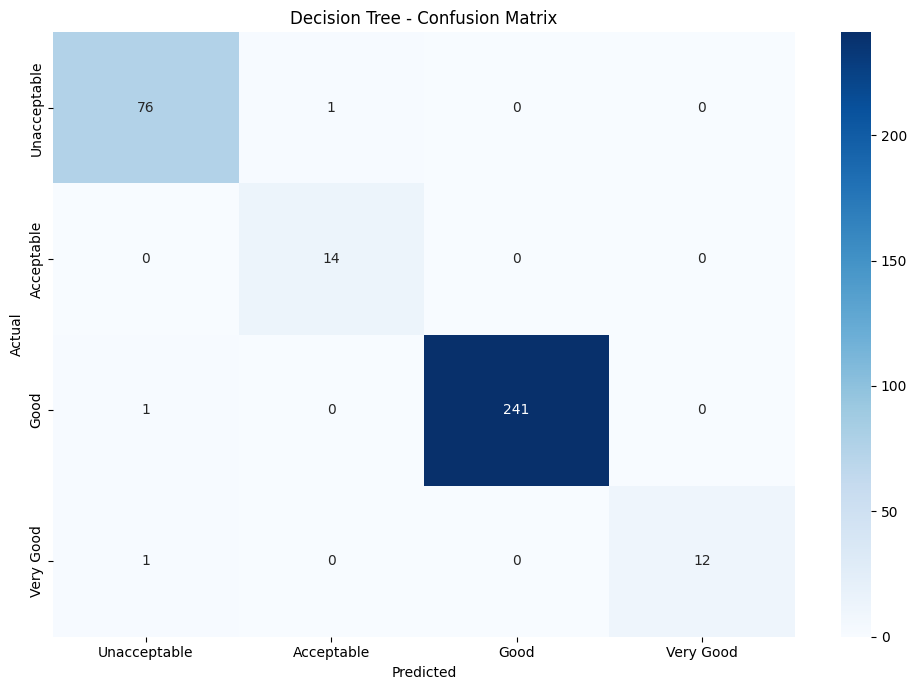

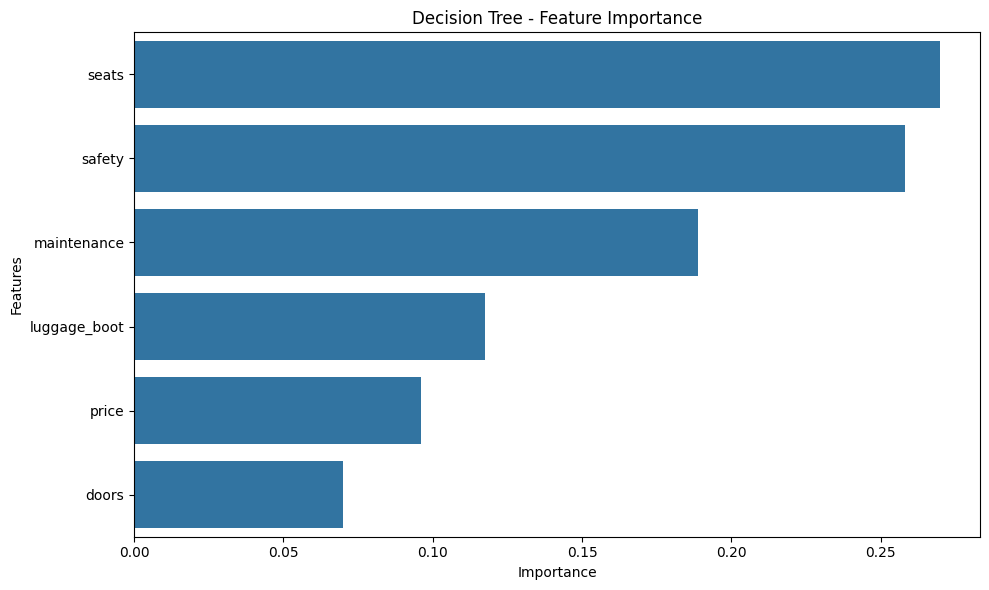

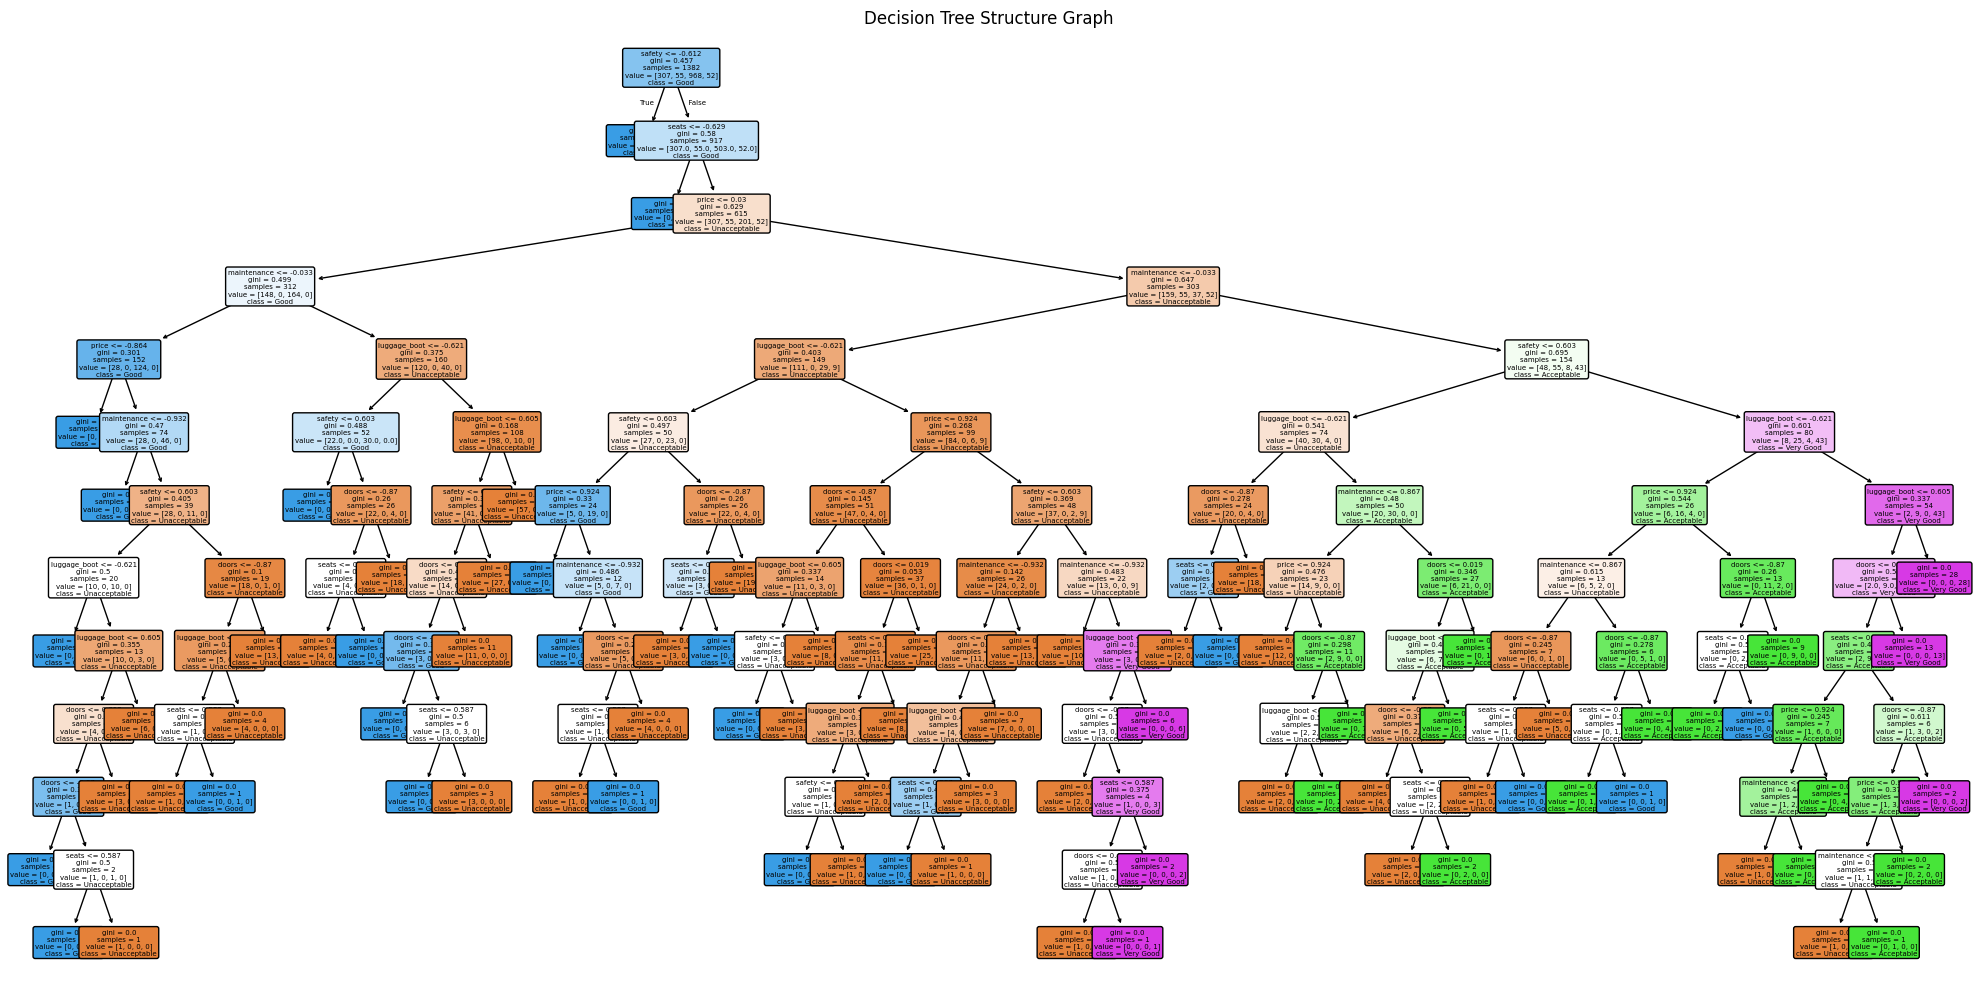


Evaluating Random Forest...
Model saved as Joblib: ..\models\random_forest\random_forest_model.joblib
Model saved as Pickle: ..\models\random_forest\random_forest_model.pkl

Random Forest Model Performance:
Training_time: 0.12 seconds
Accuracy: 0.9884
Precision: 0.9740
Recall: 0.9413
F1_score: 0.9535

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.96      1.00      0.98        77
  Acceptable       0.93      1.00      0.97        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.99       346
   macro avg       0.97      0.94      0.95       346
weighted avg       0.99      0.99      0.99       346



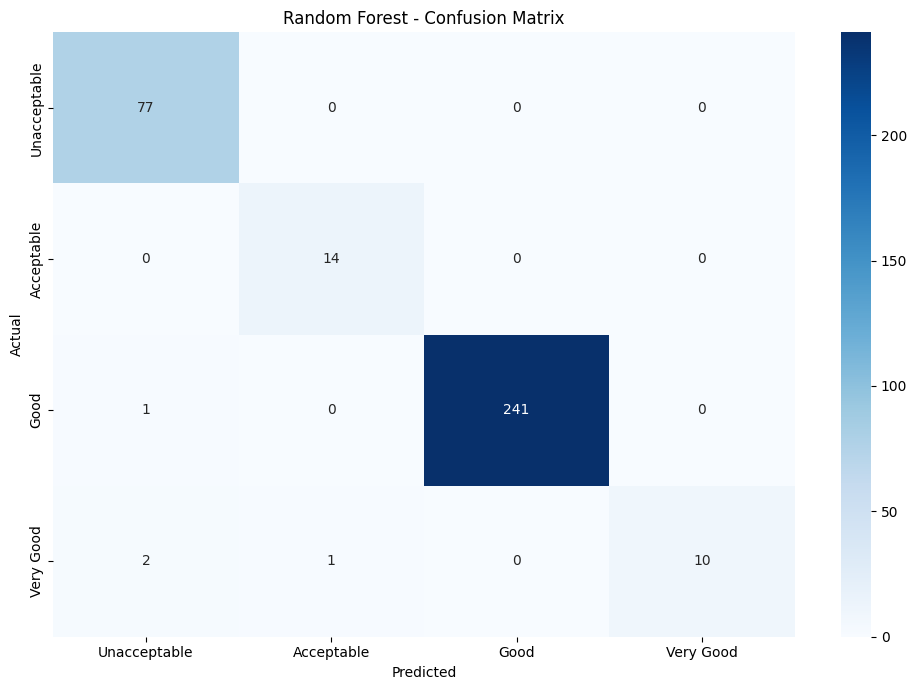

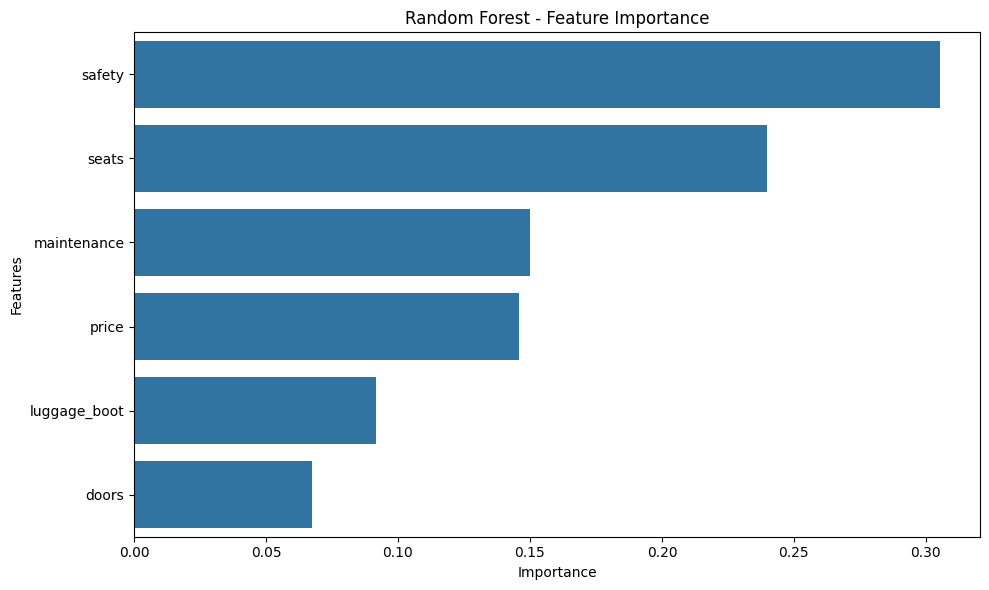

In [117]:
metrics_df = evaluate_all_models(
    model_configs,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    class_names,
    feature_names,
    graph_directory
)

### Display All Models Metrics

In [118]:
best_model_name = metrics_df['f1_score'].idxmax()
print(f"\nBest performing model: {best_model_name}")
print("\nAll models performance summary:")
print(metrics_df)


Best performing model: Decision Tree

All models performance summary:
                     training_time  accuracy  precision    recall  f1_score
model_name                                                                 
Logistic Regression       0.029302  0.838150   0.721793  0.637715  0.672660
Naive Bayes               0.001000  0.702312   0.551461  0.569067  0.437718
SVC                       0.022564  0.973988   0.976566  0.951253  0.962952
KNN                       0.004104  0.953757   0.936979  0.819079  0.865314
Decision Tree             0.003372  0.991329   0.976923  0.976489  0.976023
Random Forest             0.121085  0.988439   0.973958  0.941275  0.953476


### Optimize Best Performing Model

In [119]:
best_model, best_params, best_score = optimize_best_model(
    best_model_name,
    model_configs,
    X_train_scaled,
    y_train
)

final_metrics, final_predictions = evaluate_model_metrics(
    best_model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    f"Optimized {best_model_name}",
    class_names
)


Optimizing Decision Tree...

Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score: 0.9551
Optimization time: 132.89 seconds
Model saved as Joblib: ..\models\optimized_decision_tree\optimized_decision_tree_model.joblib
Model saved as Pickle: ..\models\optimized_decision_tree\optimized_decision_tree_model.pkl

Optimized Decision Tree Model Performance:
Training_time: 0.00 seconds
Accuracy: 0.9884
Precision: 0.9623
Recall: 0.9732
F1_score: 0.9663

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.97      0.97      0.97        77
  Acceptable       0.88      1.00      0.93        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      0.92      0.96        13

    accuracy                           

### Visualize Results

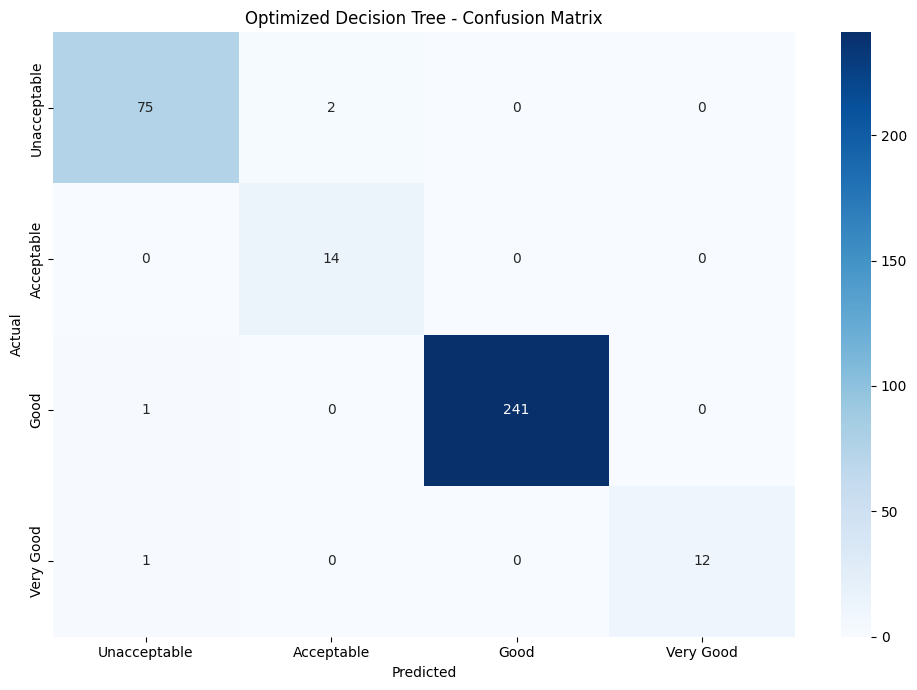

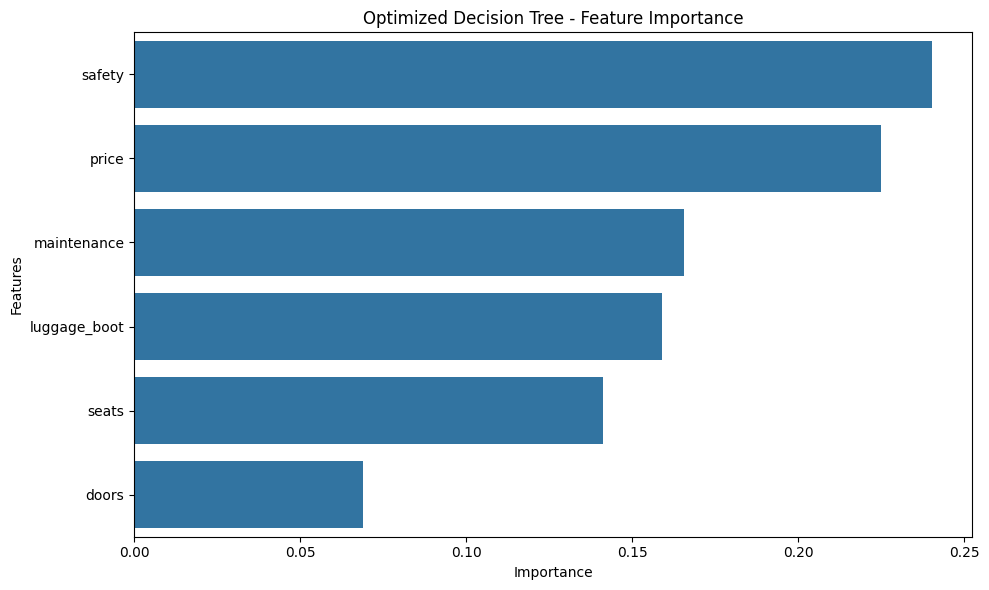

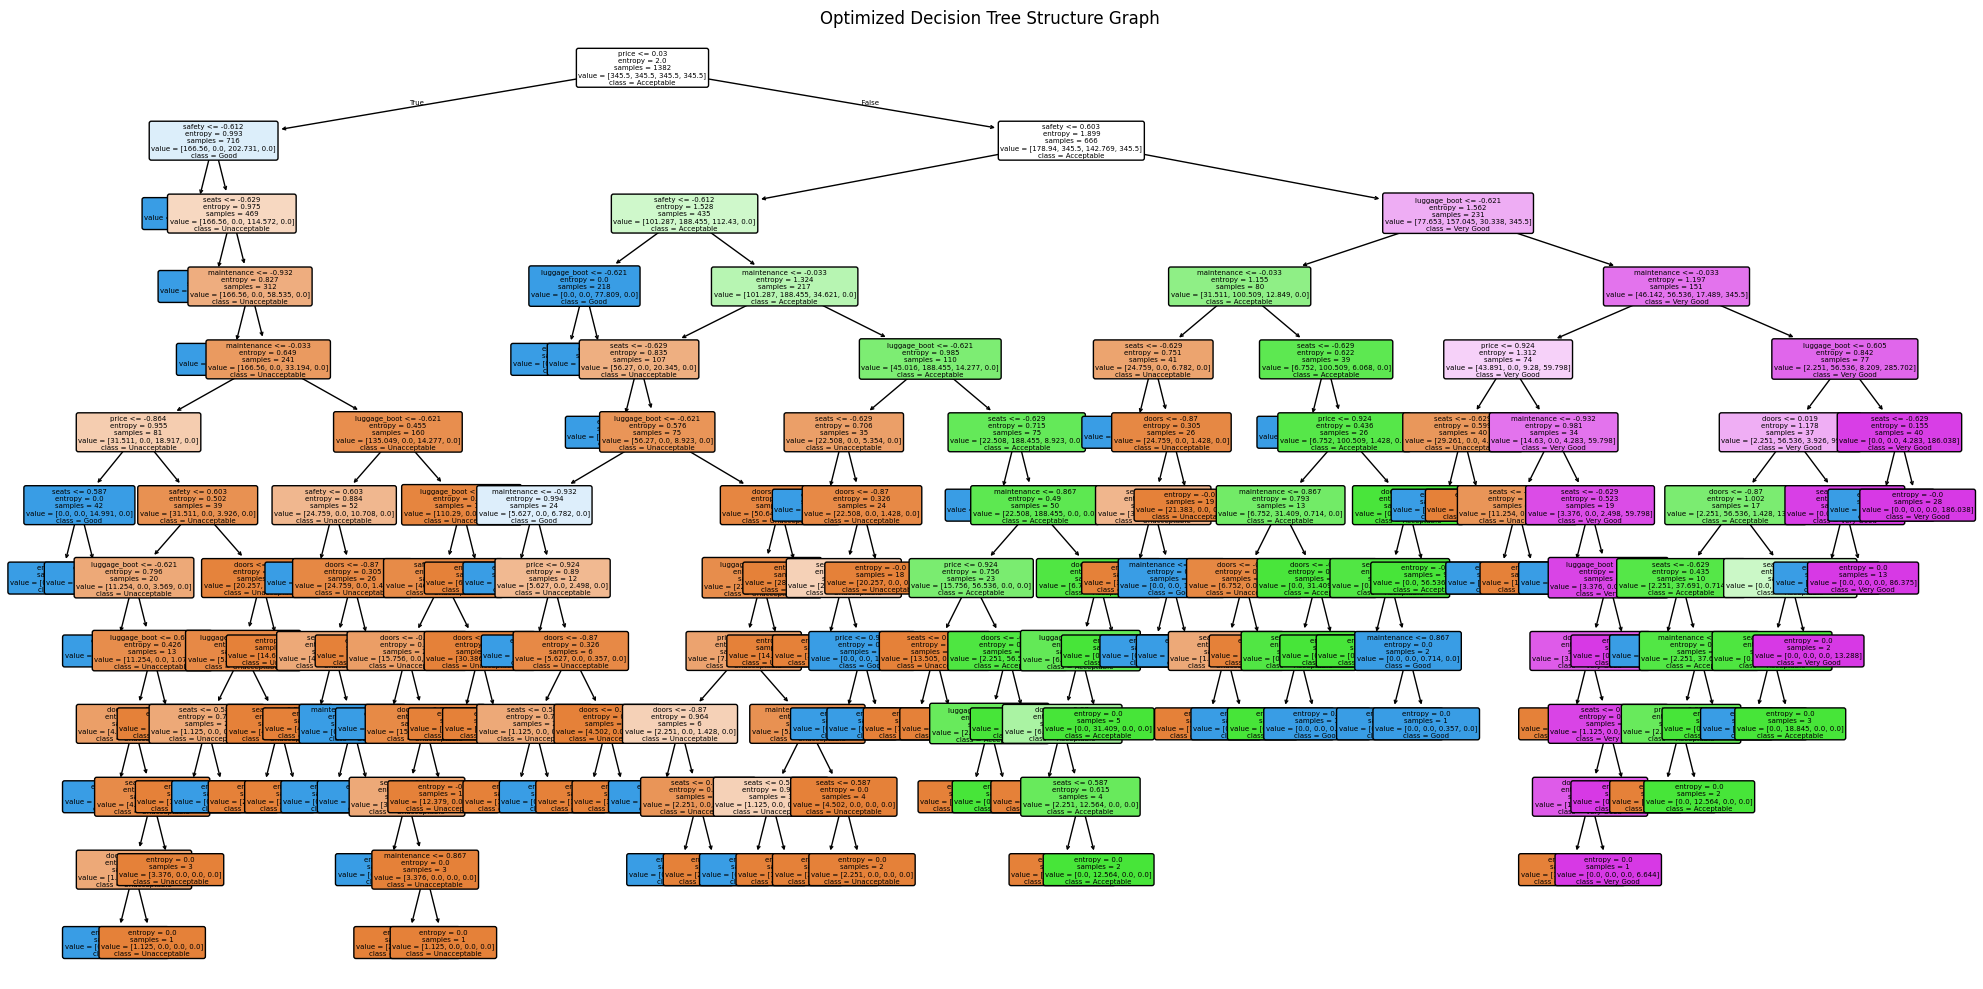

In [120]:
plot_confusion_matrix(
    y_test,
    final_predictions,
    f"Optimized {best_model_name}",
    class_names,
    graph_directory
)

plot_feature_importance(
    best_model,
    f"Optimized {best_model_name}",
    feature_names,
    graph_directory
)

if "Tree" in best_model_name:
    title = "Optimized Decision Tree Structure Graph"
    file = "optimized_decision_tree_structure_graph"
    plot_decision_tree(best_model, file, title)